In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

use_cuda = torch.cuda.is_available()

In [3]:
data_dir =  '/content/drive/My Drive/Final Project/chest_xray/chest_xray'

In [4]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      #transforms.RandomRotation(20),
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((.5,.5,.5),
                                                           (.5,.5,.5))])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((.5,.5,.5),
                                                         (.5,.5,.5))])


val_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((.5,.5,.5),
                                                         (.5,.5,.5))])


In [5]:
train_data = datasets.ImageFolder("/content/drive/My Drive/Final Project/chest_xray/chest_xray/train", train_transform)
test_data = datasets.ImageFolder("/content/drive/My Drive/Final Project/chest_xray/chest_xray/test", test_transform)
valid_data = datasets.ImageFolder("/content/drive/My Drive/Final Project/chest_xray/chest_xray/val", val_transform)

In [6]:
train_loader = DataLoader(train_data, batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=64, num_workers=2, shuffle=False, pin_memory=True)

In [7]:
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        
        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding = 1)
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)
        
        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)
        
        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 14 * 14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 2)
        
        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)
        
        self.drop = nn.Dropout(p=.3)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x), inplace=True)
        x = self.pool(self.batch1(x))
        
        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))
        
        x = x.view(-1, 64 * 14 * 14)
        
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.fc4(x)
        
        return x

In [8]:
XRayModel = XRayNet()

if use_cuda:
    XRayModel.cuda()

XRayModel

XRayNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_featur

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(XRayModel.parameters(), lr=0.001)

In [10]:
n_epoch = 30
min_val_loss = np.Inf

train_losses = []
val_losses = []

for e in range(n_epoch):
    
    running_loss = 0
    val_loss = 0
    
    # train mode
    for images, labels in train_loader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
        # zero grad
        optimizer.zero_grad()
        
        output = XRayModel(images)
        
        loss = criterion(output, labels)
        
        running_loss += loss.item() * images.size(0)
        
        loss.backward()
        
        optimizer.step()
        
    # valid mode
    for images, labels in valid_loader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
        XRayModel.eval()
        
        output = XRayModel(images)
        
        loss = criterion(output, labels)
        
        val_loss += loss.item() * images.size(0)
        
    XRayModel.train()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(valid_loader.dataset)
    print('Epoch {}, train loss : {}, validation loss :{}'.format(e, epoch_train_loss, epoch_val_loss))
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch_val_loss <= min_val_loss:
        print('Validation loss decreased {} -> {}. Saving model...'.format(min_val_loss, epoch_val_loss))
        min_val_loss = epoch_val_loss
        torch.save(XRayModel.state_dict(), 'ashish_best.pth')

Epoch 0, train loss : 0.18711559885583937, validation loss :2.197384834289551
Validation loss decreased inf -> 2.197384834289551. Saving model...
Epoch 1, train loss : 0.10627230110009603, validation loss :1.4321396350860596
Validation loss decreased 2.197384834289551 -> 1.4321396350860596. Saving model...
Epoch 2, train loss : 0.08534372633309878, validation loss :0.7264304161071777
Validation loss decreased 1.4321396350860596 -> 0.7264304161071777. Saving model...
Epoch 3, train loss : 0.08118326260586842, validation loss :0.7069476246833801
Validation loss decreased 0.7264304161071777 -> 0.7069476246833801. Saving model...
Epoch 4, train loss : 0.05346454297451482, validation loss :0.36714139580726624
Validation loss decreased 0.7069476246833801 -> 0.36714139580726624. Saving model...
Epoch 5, train loss : 0.04895686357651743, validation loss :0.26691100001335144
Validation loss decreased 0.36714139580726624 -> 0.26691100001335144. Saving model...
Epoch 6, train loss : 0.06856598163

In [11]:
XRayModel1 = XRayNet()
XRayModel1.load_state_dict(torch.load('ashish_best.pth'))

<All keys matched successfully>

In [22]:
if use_cuda:
    XRayModel1.cuda()

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

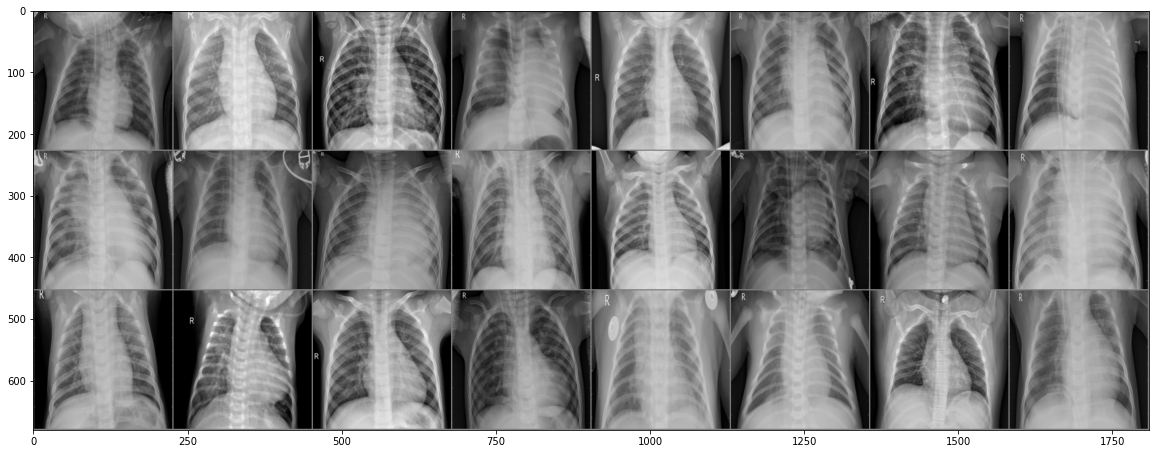

GroundTruth:  tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1)


In [13]:
import torchvision
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:24]))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(24)))

In [15]:
pip install pytorch-ignite

     |████████████████████████████████| 194kB 17.3MB/s 


In [23]:
from ignite.metrics import Accuracy, Precision, Recall

def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.round(y_pred)
    return y_pred, y

binary_accuracy = Accuracy(thresholded_output_transform)
precision = Precision(thresholded_output_transform)
recall = Recall(thresholded_output_transform)

In [24]:
def CalculateMetrics(XRayModel1):
    with torch.no_grad():
        for images, labels in test_loader:
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            outputs = XRayModel1(images)
            _, predicted = torch.max(outputs.data, 1)
            binary_accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
        print('Model accuracy : ', binary_accuracy.compute())
        print('Model Precision : ', precision.compute().item())
        print('Model Recall : ', recall.compute().item())

In [25]:
CalculateMetrics(XRayModel1)

Model accuracy :  0.8125
Model Precision :  0.782608695652174
Model Recall :  0.9692307692307692
